## Health Insurance Lead Prediction

Problem Statement: Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

Now the company needs your help in building a model to predict whether the person will be interested in their proposed Health plan/policy.

In [7]:
# Scientific and Data Manipulation Libraries :

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Viz & Regular Expression Libraries :

import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

# Scikit-Learn Pre-Processing Libraries :

from sklearn.preprocessing import *

# Garbage Collection Libraries :

import gc

# Boosting Algorithm Libraries :

from xgboost                          import XGBClassifier
# from catboost                         import CatBoostClassifier, Pool
# from lightgbm                         import LGBMClassifier
# from sklearn.ensemble                 import RandomForestClassifier, VotingClassifier

# Model Evaluation Metric & Cross Validation Libraries :
from sklearn.metrics                  import roc_auc_score
from sklearn.model_selection          import StratifiedKFold,KFold, RepeatedStratifiedKFold, train_test_split

# Setting SEED to Reproduce Same Results even with "GPU" :
seed_value = 1994

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
SEED=seed_value

In [8]:
# Reading files

train = pd.read_csv('train_Df64byy.csv')
test = pd.read_csv('test_YCcRUnU.csv')
sub = pd.read_csv('sample_submission_QrCyCoT.csv')

## EDA

In [8]:
print(f'Train set has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test set has {test.shape[0]} rows and {test.shape[1]} columns.')

Train set has 50882 rows and 14 columns.
Test set has 21805 rows and 13 columns.


In [3]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [11]:
print('Percentage of missing values in each column')
train.isnull().sum()/train.shape[0]*100

Percentage of missing values in each column


ID                          0.000000
City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Upper_Age                   0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health Indicator           22.976691
Holding_Policy_Duration    39.799929
Holding_Policy_Type        39.799929
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
Response                    0.000000
dtype: float64

In [9]:
print('There are no duplicate values.') if raw_data_train.duplicated().sum()==0 else print('Duplicates found!!')

There are no duplicate values.


In [16]:
print('Number of unique values in categorical column.')
cat_col = ['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Is_Spouse','Health Indicator',
        'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat']
train[cat_col].nunique()

Number of unique values in categorical column.


City_Code                    36
Region_Code                5316
Accomodation_Type             2
Reco_Insurance_Type           2
Is_Spouse                     2
Health Indicator              9
Holding_Policy_Duration      15
Holding_Policy_Type           4
Reco_Policy_Cat              22
dtype: int64

* There are missing values in only 3 columns namely Health Indicator, Holding_Policy_Duration and Holding_Policy_Type. Since these are categorical columns and no domain knowledge can be gathered about their classes, I will impute missing values using mode. Alternatively, filling them with some constant say 0 also gives same result.
* There are no duplicate values in train data.
* Region_Code feature has very large number of distinct classes. I tried frequency encoding for it but no major improvement was achieved in score.
* Features Accomodation_Type, Reco_Insurance_Type and Is_Spouse have only two distinct classes so I will do binary encoding for them.
* For other features I tried to reduce number of distinct classes using their frequency and response rate but score reached only 0.62. I also tried using FeatureHasher function from sklearn.feature_extraction but score reached only 0.59.
* So,finally I simply one hot encoded these features using get_dummies function from pandas.

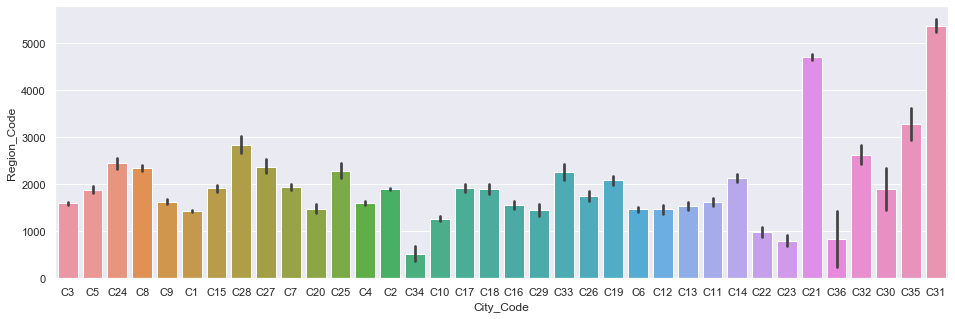

In [61]:
plt.figure(figsize=(16,5))
sns.barplot(data=train,x='City_Code',y='Region_Code');

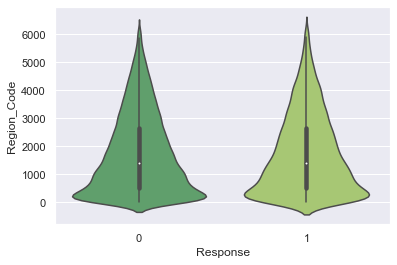

In [58]:
sns.violinplot(data=train,x='Response',y='Region_Code',palette='summer');

There is no information about Region_Code and no pattern with respect to the target variable. So I cannot transform it much.

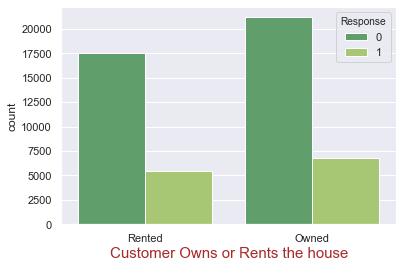

In [62]:
sns.set_style('darkgrid')
sns.countplot(data=train,x='Accomodation_Type',hue='Response',palette='summer')
plt.xlabel('Customer Owns or Rents the house',fontdict={'fontsize': 15,'color':'Brown'},labelpad=3);

Customers wh own a house are more likely to give positive response.

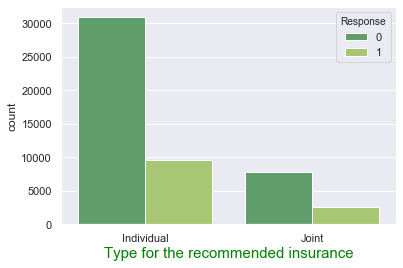

In [63]:
sns.set_style('darkgrid')
sns.countplot(data=train,x='Reco_Insurance_Type',hue='Response',palette='summer')
plt.xlabel('Type for the recommended insurance',fontdict={'fontsize': 15,'color':'Green'},labelpad=3);

Customers have mostly showed interest in Individual insurance. Though response rate seems similar for both.

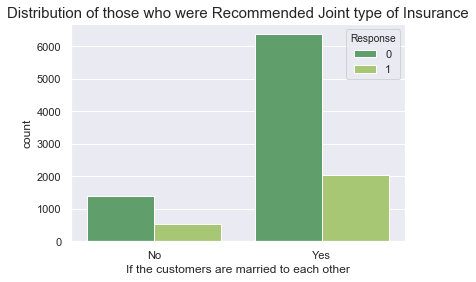

In [67]:
sns.countplot(data=train[train['Reco_Insurance_Type']=='Joint'],x='Is_Spouse',hue='Response',palette='summer')
plt.xlabel('If the customers are married to each other')
plt.title('Distribution of those who were Recommended Joint type of Insurance',fontsize=15);

Customers showing interest in joint insurance are mostly couples.

Distribution of Age of primary customer.


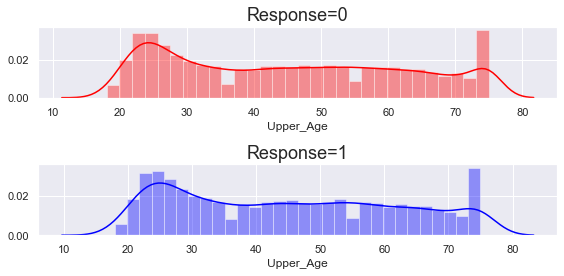

In [54]:
print('Distribution of Age of primary customer.')
fig,axes=plt.subplots(2,1,figsize=(8,4))
sns.distplot(train[train['Response']==0]['Upper_Age'],bins=30,color='red',ax=axes[0])
axes[0].set_title('Response=0',fontsize=18)
sns.distplot(train[train['Response']==1]['Upper_Age'],bins=30,color='blue',ax=axes[1])
axes[1].set_title('Response=1',fontsize=18)
plt.tight_layout();

Age does not seem to affect target variable.

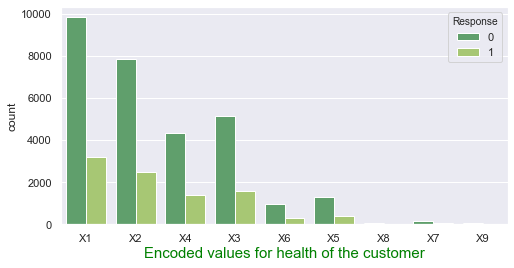

In [49]:
plt.figure(figsize=(8,4))
sns.countplot(data=train,x='Health Indicator',hue='Response',palette='summer')
plt.xlabel('Encoded values for health of the customer',fontdict={'fontsize': 15,'color':'Green'},labelpad=3);

As Health Indicator goes from X1 to X9 customer is less likely to be a lead.

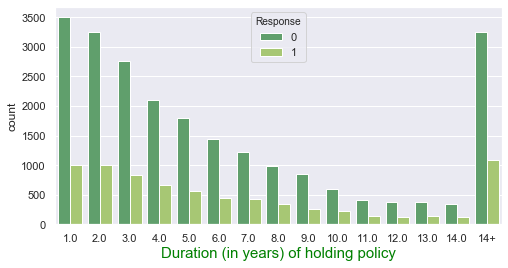

In [41]:
plt.figure(figsize=(8,4))
sns.countplot(data=train,x='Holding_Policy_Duration',hue='Response',palette='summer',
              order=['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0',
       '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0','14+'])
plt.xlabel('Duration (in years) of holding policy',fontdict={'fontsize': 15,'color':'Green'},labelpad=3);

Majority of customers hold policies of less than 5 years. As number of years increases, probability of response 1 decreases. Possible reason can be people don't take multiple policies. Class 14+ seems heavier may be because it include many classes.

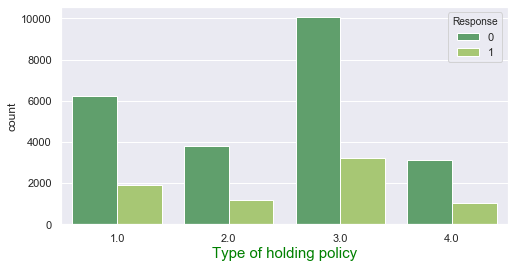

In [36]:
plt.figure(figsize=(8,4))
sns.countplot(data=train,x='Holding_Policy_Type',hue='Response',palette='summer')
plt.xlabel('Type of holding policy',fontdict={'fontsize': 15,'color':'Green'},labelpad=3);

Policy corresponding to 3.0 seems most popular.

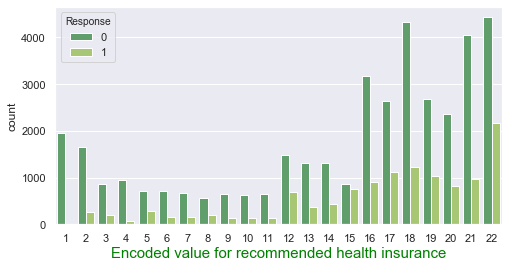

In [21]:
plt.figure(figsize=(8,4))
sns.countplot(data=train,x='Reco_Policy_Cat',hue='Response',palette='summer')
plt.xlabel('Encoded value for recommended health insurance',fontdict={'fontsize': 15,'color':'Green'},labelpad=3);

Insurance policies corresponding to 16-22 are most likely.

Annual Premium (INR) for the recommended health insurance


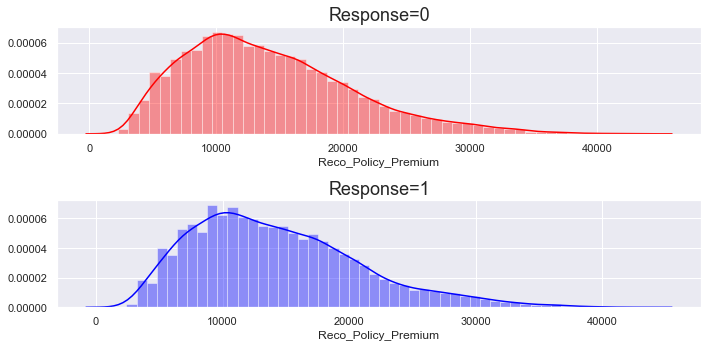

In [47]:
print('Annual Premium (INR) for the recommended health insurance')
fig,axes=plt.subplots(2,1,figsize=(10,5))
sns.distplot(train[train['Response']==0]['Reco_Policy_Premium'],color='red',ax=axes[0])
axes[0].set_title('Response=0',fontsize=18)
sns.distplot(train[train['Response']==1]['Reco_Policy_Premium'],color='blue',ax=axes[1])
axes[1].set_title('Response=1',fontsize=18)
plt.tight_layout();

Annual Premium distribution is similar fot both the classes.

## Preprocessing

In [9]:
# Joining training and test data for preprocessing
full_df=pd.concat([train,test])

# Creating a new feature by combining 'Upper_Age' and 'Lower_Age'
full_df['Age']=full_df.Upper_Age-full_df.Lower_Age

# Label encoding categorical features with two classes
full_df.Is_Spouse = full_df.Is_Spouse.map({'No':0,'Yes':1})
full_df.Reco_Insurance_Type = full_df.Reco_Insurance_Type.map({'Individual':0,'Joint':1})
full_df.Accomodation_Type = full_df.Accomodation_Type.map({'Owned':0,'Rented':1})

# Filling missing values with mode
for i in ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']:
    full_df[i].fillna(0,inplace=True)
for i in ['Reco_Policy_Cat','Holding_Policy_Type']:
    full_df[i] = full_df[i].astype(object)

# One hot encoding categorical features with multiple classes
dummies = pd.get_dummies(full_df[['City_Code','Health Indicator','Holding_Policy_Duration','Holding_Policy_Type','Reco_Policy_Cat']],drop_first=True)
final_data = pd.concat([full_df,dummies],axis=1)
final_data.drop(['ID','City_Code','Health Indicator','Lower_Age','Holding_Policy_Duration','Holding_Policy_Type','Reco_Policy_Cat'],axis=1,inplace=True)
final_data.head()

,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Is_Spouse,Reco_Policy_Premium,Response,Age,City_Code_C10,City_Code_C11,...,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22
0,3213,1,0,36,0,11628.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1117,0,1,75,0,30510.0,0.0,53,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3732,0,0,32,0,7450.0,1.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4378,0,1,52,0,17780.0,0.0,4,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2190,1,0,44,0,10404.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [10]:
# Splitting combined data into preprocessed train and test data
train_data=final_data.dropna()
test_data = final_data.iloc[50882:]
test_data.drop('Response',axis=1,inplace=True)
train_data.shape,test_data.shape

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((50882, 92), (21805, 91))

In [1]:
# Scaling the data - this didn't make much difference in score so I dropped it

# X=train_data.drop('Response',axis=1)
# y=train_data.Response
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

# to_be_scaled_feat = [ 'Age','Reco_Policy_Premium','Upper_Age', 'Region_Code']
# scaler=StandardScaler()
# scaler.fit(train_data[to_be_scaled_feat])
# X_train[to_be_scaled_feat] = scaler.transform(X_train[to_be_scaled_feat])
# X_test[to_be_scaled_feat] = scaler.transform(X_test[to_be_scaled_feat])

### XGBoost model cross-validated with 10 folds

In [12]:
predictor_train_scale = train_data.drop('Response',axis=1)
predictor_test_scale = test_data
target_train = train_data.Response

In [18]:
# making 10 folds
kf=KFold(n_splits=10,shuffle=True)

preds_3   = list()
y_pred_3  = []
rocauc_score = []

# Applying model on each fold and calculating mean of score
for i,(train_idx,val_idx) in enumerate(kf.split(predictor_train_scale)):    
    
    X_train, y_train = predictor_train_scale.iloc[train_idx,:], target_train.iloc[train_idx]    
    X_val, y_val = predictor_train_scale.iloc[val_idx, :], target_train.iloc[val_idx]
   
    print('\nFold: {}\n'.format(i+1))

    xg=XGBClassifier( eval_metric='auc',
        
                     # GPU PARAMETERS #
                     tree_method='gpu_hist', 
                     gpu_id=0,
                     # GPU PARAMETERS #
        
                     random_state=294,
                     learning_rate=0.15, 
                     max_depth=4,
                     n_estimators=494, 
                     objective='binary:logistic'
                    )

    xg.fit(X_train, y_train
           ,eval_set=[(X_train, y_train),(X_val, y_val)]
           ,early_stopping_rounds=100
           ,verbose=100
           )

    roc_auc = roc_auc_score(y_val,xg.predict_proba(X_val)[:, 1])
    rocauc_score.append(roc_auc)
    preds_3.append(xg.predict_proba(predictor_test_scale[predictor_test_scale.columns])[:, 1])
    
y_pred_final_3         = np.mean(preds_3,axis=0)    
sub['Response']=y_pred_final_3

print('ROC_AUC - CV Score: {}'.format((sum(rocauc_score)/10)),'\n')
print("Score : ",rocauc_score)

# Download and Show Submission File :

display("sample_submmission",sub)
sub_file_name_3 = "S3. XGB_GPU_1994SEED_LGBM_NoScaler_MyStyle.csv"
sub.to_csv(sub_file_name_3,index=False)
Blend_model_3 = sub.copy()
sub.head(5)


Fold: 1



/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.58018	validation_1-auc:0.58197
[100]	validation_0-auc:0.70395	validation_1-auc:0.66245
[200]	validation_0-auc:0.73579	validation_1-auc:0.67098
[300]	validation_0-auc:0.75703	validation_1-auc:0.67652
[400]	validation_0-auc:0.77539	validation_1-auc:0.67857
[493]	validation_0-auc:0.78773	validation_1-auc:0.68116

Fold: 2

[0]	validation_0-auc:0.58032	validation_1-auc:0.57922


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.70390	validation_1-auc:0.66406
[200]	validation_0-auc:0.73308	validation_1-auc:0.66936
[300]	validation_0-auc:0.75586	validation_1-auc:0.67512
[400]	validation_0-auc:0.77380	validation_1-auc:0.67434
[422]	validation_0-auc:0.77675	validation_1-auc:0.67566

Fold: 3

[0]	validation_0-auc:0.58125	validation_1-auc:0.57094


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.70126	validation_1-auc:0.66164
[200]	validation_0-auc:0.73177	validation_1-auc:0.67166
[300]	validation_0-auc:0.75473	validation_1-auc:0.67599
[400]	validation_0-auc:0.77206	validation_1-auc:0.67908
[493]	validation_0-auc:0.78591	validation_1-auc:0.68157

Fold: 4

[0]	validation_0-auc:0.58081	validation_1-auc:0.57549


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.70183	validation_1-auc:0.66588
[200]	validation_0-auc:0.73392	validation_1-auc:0.67915
[300]	validation_0-auc:0.75632	validation_1-auc:0.68424
[400]	validation_0-auc:0.77236	validation_1-auc:0.68786
[493]	validation_0-auc:0.78537	validation_1-auc:0.69055

Fold: 5

[0]	validation_0-auc:0.57895	validation_1-auc:0.59255


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.70421	validation_1-auc:0.68207
[200]	validation_0-auc:0.73551	validation_1-auc:0.68783
[300]	validation_0-auc:0.75728	validation_1-auc:0.68854
[400]	validation_0-auc:0.77431	validation_1-auc:0.69192
[493]	validation_0-auc:0.78691	validation_1-auc:0.69314

Fold: 6

[0]	validation_0-auc:0.58092	validation_1-auc:0.57048


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.70197	validation_1-auc:0.66919
[200]	validation_0-auc:0.73325	validation_1-auc:0.68226
[300]	validation_0-auc:0.75499	validation_1-auc:0.68462
[400]	validation_0-auc:0.77275	validation_1-auc:0.68724
[493]	validation_0-auc:0.78622	validation_1-auc:0.68866

Fold: 7

[0]	validation_0-auc:0.58081	validation_1-auc:0.57168


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.70197	validation_1-auc:0.65991
[200]	validation_0-auc:0.73252	validation_1-auc:0.67113
[300]	validation_0-auc:0.75423	validation_1-auc:0.67844
[400]	validation_0-auc:0.77297	validation_1-auc:0.68095
[493]	validation_0-auc:0.78697	validation_1-auc:0.68545

Fold: 8

[0]	validation_0-auc:0.57996	validation_1-auc:0.58210


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.70205	validation_1-auc:0.67150
[200]	validation_0-auc:0.73447	validation_1-auc:0.67849
[300]	validation_0-auc:0.75733	validation_1-auc:0.67978
[400]	validation_0-auc:0.77440	validation_1-auc:0.68176
[493]	validation_0-auc:0.78606	validation_1-auc:0.68353

Fold: 9

[0]	validation_0-auc:0.57927	validation_1-auc:0.58887


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.70179	validation_1-auc:0.67373
[200]	validation_0-auc:0.73278	validation_1-auc:0.67665
[300]	validation_0-auc:0.75571	validation_1-auc:0.67840
[400]	validation_0-auc:0.77370	validation_1-auc:0.67804
[425]	validation_0-auc:0.77766	validation_1-auc:0.67833

Fold: 10

[0]	validation_0-auc:0.57989	validation_1-auc:0.58086


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.70421	validation_1-auc:0.66246
[200]	validation_0-auc:0.73538	validation_1-auc:0.66572
[300]	validation_0-auc:0.75610	validation_1-auc:0.66738
[393]	validation_0-auc:0.77202	validation_1-auc:0.66697
ROC_AUC - CV Score: 0.682759463677978 

Score :  [0.681384649836329, 0.6759605121026763, 0.6815741308213611, 0.6905480235968855, 0.6931456458610258, 0.6886650430298965, 0.6855595706565126, 0.6836819286113965, 0.6791139004866633, 0.6679612317770327]


'sample_submmission'

,ID,Response
0,50883,0.346687
1,50884,0.301421
2,50885,0.303253
3,50886,0.204151
4,50887,0.240147
...,...,...
21800,72683,0.130468
21801,72684,0.215245
21802,72685,0.137936
21803,72686,0.327804


,ID,Response
0,50883,0.346687
1,50884,0.301421
2,50885,0.303253
3,50886,0.204151
4,50887,0.240147


### Final score is 0.68